In [1]:
import os
import statistics
from typing import Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def load_csv_result_data_variant_counts(optimization, scenario, variant_counts, scale_factor):
    result_df = None
    for variant_count in variant_counts:
        filepath = f"{os.getcwd()}/optimization-benchmark-results/" \
                   f"results-{optimization}-{scenario}-{variant_count}-{scale_factor}.csv"
        new_df = pd.read_csv(filepath)
        repeats = new_df.shape[0]
        median_no_opt = new_df['analysis_result_without_any_opt'].median()
        # avg_baseline_variant_execution = median_no_opt / variant_count
        new_df['original_pipeline'] = new_df['original_pipeline'].median()
        for column in new_df.columns:
            if column.startswith("analysis_result"):
                new_df[column] = median_no_opt / new_df[column].median()
        new_df = new_df.head(1)
        new_df['repeats'] = repeats
        new_df['variant_count'] = variant_count
        new_df['scale_factor'] = scale_factor
        if result_df is None:
            result_df = new_df
        else:
            result_df = pd.concat([result_df, new_df], axis=0)
    return result_df

def load_csv_result_data_scale_factors(optimization, scenario, scale_factors, variant_count):
    result_df = None
    max_runtime = 0.
    max_runtime_column = ""
    max_runtime_optimization = ""
    max_runtime_scenario = ""
    max_runtime_scale_factor = ""
    for scale_factor in scale_factors:
        filepath = f"{os.getcwd()}/optimization-benchmark-results/" \
                   f"results-{optimization}-{scenario}-{variant_count}-{scale_factor}.csv"
        new_df = pd.read_csv(filepath)
        repeats = new_df.shape[0]
        median_no_opt = new_df['analysis_result_without_any_opt'].median()
        # avg_baseline_variant_execution = median_no_opt / variant_count
        new_df['original_pipeline'] = new_df['original_pipeline'].median()
        for column in new_df.columns:
            if column.startswith("analysis_result"):
                if new_df[column].median() >= max_runtime:
                    max_runtime = median_no_opt
                    max_runtime_column = column
                    max_runtime_optimization = optimization
                    max_runtime_scenario = scenario
                    max_runtime_scale_factor = scale_factor
                new_df[column] = median_no_opt / new_df[column].median()
        new_df = new_df.head(1)
        new_df['repeats'] = repeats
        new_df['variant_count'] = variant_count
        new_df['scale_factor'] = scale_factor
        if result_df is None:
            result_df = new_df
        else:
            result_df = pd.concat([result_df, new_df], axis=0)
    print("max_runtime_seen")
    print(max_runtime)
    print(max_runtime_column)
    print(max_runtime_optimization)
    print(max_runtime_scenario)
    print(max_runtime_scale_factor)

    return result_df

In [3]:
def plot_runtimes(scenario_name_to_named_metrics: Dict[str, Tuple[float, float]],
                  variant_counts, title):

    markersize = 12

    #plt.plot(1.0 / epsilons, adult_means / np.min(adult_means), 'o-', markersize=markersize)

    # plt.plot(variant_counts, np.array(orig), linestyle='dotted', color='grey')
    # styles = [{'color': 'tab:green'}, {'color': 'tab:blue'}, {'color': 'tab:red'}, {'color': 'tab:orange'}, {'color': 'tab:red', 'linestyle': 'dashed'}, {'color': 'tab:purple', 'linestyle': 'dashed'}]
    styles = [{'color': 'tab:green'}, {'color': 'tab:blue'}, {'color': 'tab:red'}, {'color': 'tab:orange'}, {'color': 'tab:pink'}, {'color': 'tab:purple'}]


    for (scenario, (metric_with_opt, metric_witout_opt)), style in zip(scenario_name_to_named_metrics.items(), styles):
        plt.plot(variant_counts, np.array(metric_with_opt), marker='o', **style)
        plt.plot(variant_counts, np.array(metric_witout_opt), linestyle='dashed', marker='o', **style)


    #plt.ylim((0.9, 5.999))
    # plt.grid()
    # plt.gca().set_aspect("equal")

    plt.ylabel('speedup', fontsize=26)
    legend_names = []
    for scenario_name in scenario_name_to_named_metrics.keys():
        with_opt_desc, without_opt_desc = scenario_name.split(';', 2)
        legend_names.append(f"{with_opt_desc}")  #  w/ opt.
        legend_names.append(f"{without_opt_desc}")
    plt.legend(legend_names, loc='upper left',
               #, title="inspections", title_fontsize=16,
               fontsize=15, ncol=1)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

    #plt.xticks(variant_counts[1:], rotation=45, fontsize=24)
    plt.xticks(variant_counts, rotation=0, fontsize=24)
    # plt.xticks(list(range(2, variant_counts[-1])), rotation=0, fontsize=24)


    if isinstance(variant_counts[-1], int):  # TODO: Do this in a less hacky way
        # variant counts
        plt.xlabel('# variants', fontsize=26)
        plt.yticks(list(range(variant_counts[-1])))
        plt.ylim(0, variant_counts[-1])
    else:
        # scale factors
        plt.xlabel('scale factor', fontsize=26)
        plt.yticks(variant_counts)
        plt.yticks(list(range(5)))
        plt.ylim(0, 4.5)

    #plt.yscale('log')
    #plt.xscale('log')


    #plt.title(title, fontsize=26)

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

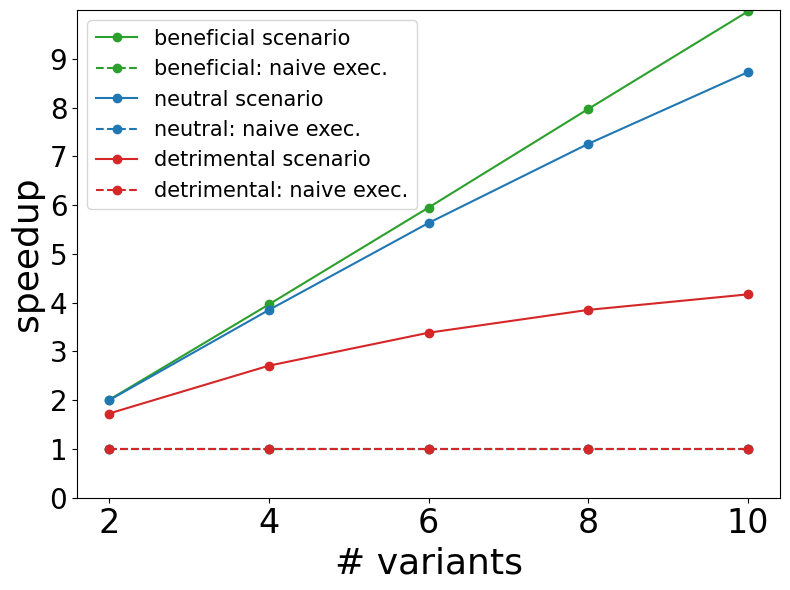

In [4]:
optimization = "common_subexpression_elimination"
variant_counts = [2, 4, 6, 8, 10]
row_count = "1.0"
ideal_df = load_csv_result_data_variant_counts(optimization, "ideal", variant_counts, row_count)
average_df = load_csv_result_data_variant_counts(optimization, "average", variant_counts, row_count)
worst_df = load_csv_result_data_variant_counts(optimization, "worst", variant_counts, row_count)
plot_runtimes({'beneficial scenario;beneficial: naive exec.': (ideal_df['analysis_result_with_opt'], ideal_df['analysis_result_without_any_opt']),
               'neutral scenario;neutral: naive exec.': (average_df['analysis_result_with_opt'], average_df['analysis_result_without_any_opt']),
               'detrimental scenario;detrimental: naive exec.': (worst_df['analysis_result_with_opt'], worst_df['analysis_result_without_any_opt'])},
              variant_counts,
              f"{optimization}_variant_counts")

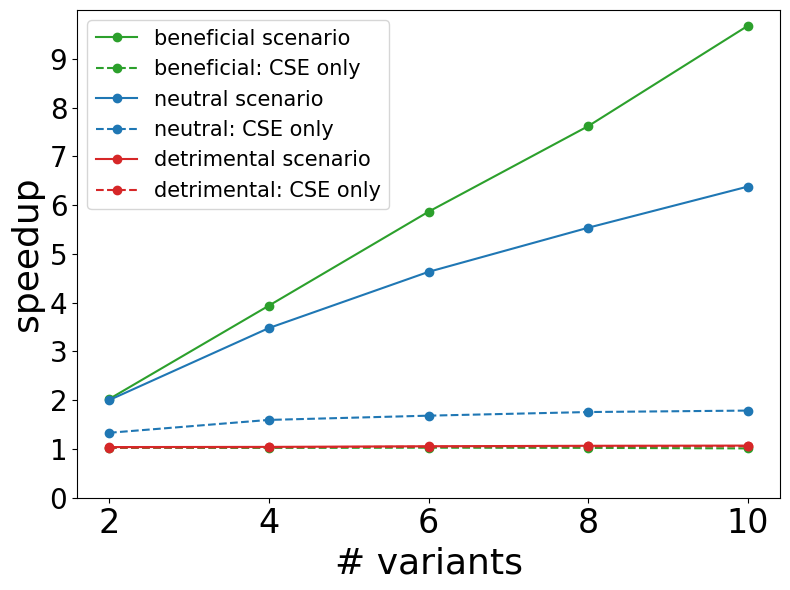

In [5]:
optimization = "projection_push_up"
variant_counts = [2, 4, 6, 8, 10]
row_count = "1.0"
ideal_df = load_csv_result_data_variant_counts(optimization, "ideal", variant_counts, row_count)
average_df = load_csv_result_data_variant_counts(optimization, "average", variant_counts, row_count)
worst_df = load_csv_result_data_variant_counts(optimization, "worst", variant_counts, row_count)
plot_runtimes({'beneficial scenario;beneficial: CSE only': (ideal_df['analysis_result_with_opt_rule'], ideal_df['analysis_result_without_opt_rule']),
               'neutral scenario;neutral: CSE only': (average_df['analysis_result_with_opt_rule'], average_df['analysis_result_without_opt_rule']),
               'detrimental scenario;detrimental: CSE only': (worst_df['analysis_result_with_opt_rule'], worst_df['analysis_result_without_opt_rule'])},
              variant_counts,
              f"{optimization}_variant_counts")

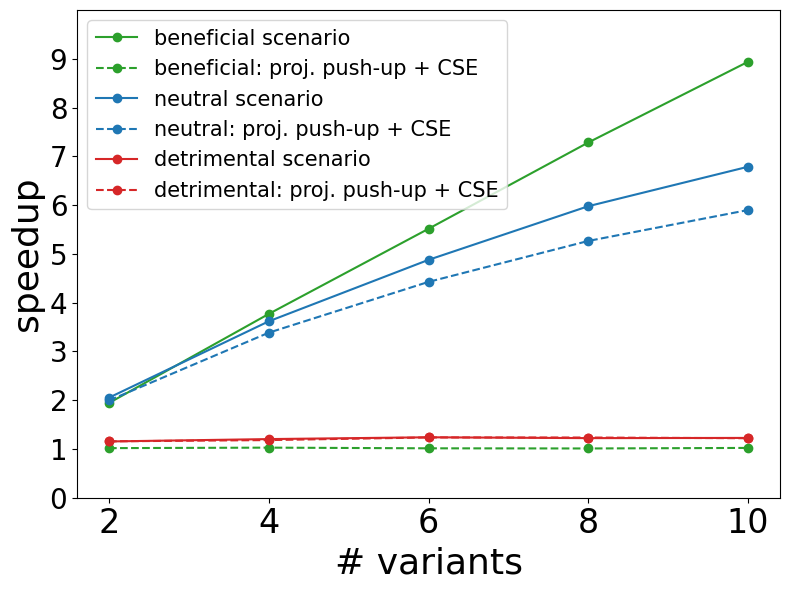

In [6]:
optimization = "udf_split_and_reuse"
variant_counts = [2, 4, 6, 8, 10]
row_count = "1.0"
ideal_df = load_csv_result_data_variant_counts(optimization, "ideal", variant_counts, row_count)
average_df = load_csv_result_data_variant_counts(optimization, "average", variant_counts, row_count)
worst_w_safety_df = load_csv_result_data_variant_counts(optimization, "worst_w_safety", variant_counts, row_count)
worst_wo_safety_df = load_csv_result_data_variant_counts(optimization, "worst_wo_safety", variant_counts, row_count)
worst_constant_df = load_csv_result_data_variant_counts(optimization, "worst_constant", variant_counts, row_count)

plot_runtimes({'beneficial scenario;beneficial: proj. push-up + CSE': (ideal_df['analysis_result_with_reuse_opt_rule'], ideal_df['analysis_result_with_push_up_opt_rule']),
               'neutral scenario;neutral: proj. push-up + CSE': (average_df['analysis_result_with_reuse_opt_rule'], average_df['analysis_result_with_push_up_opt_rule']),
               'detrimental scenario;detrimental: proj. push-up + CSE': (worst_w_safety_df['analysis_result_with_reuse_opt_rule'], worst_w_safety_df['analysis_result_with_push_up_opt_rule']),
               #'detrimental scenario: w/o safety': (worst_wo_safety_df['analysis_result_with_reuse_opt_rule'], worst_wo_safety_df['analysis_result_with_push_up_opt_rule']),
               #'detrimental scenario: constant': (worst_constant_df['analysis_result_with_reuse_opt_rule'], worst_constant_df['analysis_result_with_push_up_opt_rule'])
               },
              variant_counts,
              f"{optimization}_variant_counts")

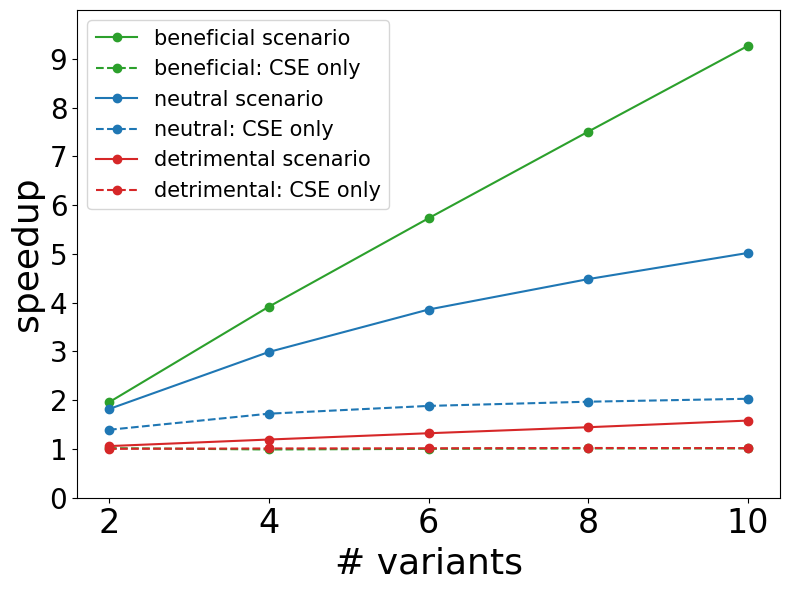

In [7]:
optimization = "filter_addition_push_up"
variant_counts = [2, 4, 6, 8, 10]
row_count = "1.0"
ideal_df = load_csv_result_data_variant_counts(optimization, "ideal", variant_counts, row_count)
average_df = load_csv_result_data_variant_counts(optimization, "average", variant_counts, row_count)
worst_wo_original_df = load_csv_result_data_variant_counts(optimization, "worst_wo_original", variant_counts, row_count)
worst_w_original_df = load_csv_result_data_variant_counts(optimization, "worst_w_original", variant_counts, row_count)
plot_runtimes({'beneficial scenario;beneficial: CSE only': (ideal_df['analysis_result_with_opt_rule'], ideal_df['analysis_result_without_opt_rule']),
               'neutral scenario;neutral: CSE only': (average_df['analysis_result_with_opt_rule'], average_df['analysis_result_without_opt_rule']),
               #'detrimental: w/o original': (worst_wo_original_df['analysis_result_with_opt_rule'], worst_wo_original_df['analysis_result_without_opt_rule']),
               'detrimental scenario;detrimental: CSE only': (worst_w_original_df['analysis_result_with_opt_rule'], worst_w_original_df['analysis_result_without_opt_rule'])},
              variant_counts,
              f"{optimization}_variant_counts")

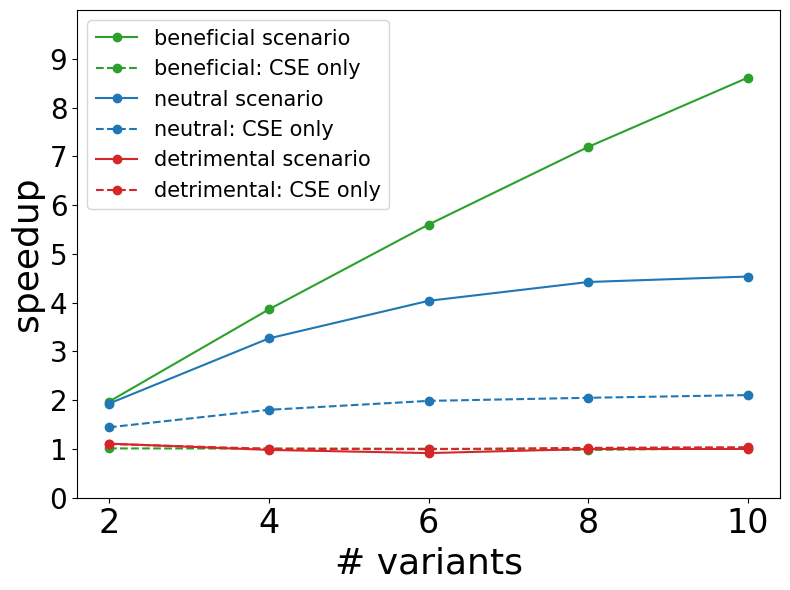

In [8]:
optimization = "operator_deletion_filter_push_up"
variant_counts = [2, 4, 6, 8, 10]
row_count = "1.0"
ideal_df = load_csv_result_data_variant_counts(optimization, "ideal", variant_counts, row_count)
average_df = load_csv_result_data_variant_counts(optimization, "average", variant_counts, row_count)
worst_wo_safety_df = load_csv_result_data_variant_counts(optimization, "worst_wo_safety", variant_counts, row_count)
worst_w_safety_df = load_csv_result_data_variant_counts(optimization, "worst_w_safety", variant_counts, row_count)
worst_safety_too_defensive_df = load_csv_result_data_variant_counts(optimization, "worst_safety_too_defensive", variant_counts, row_count)
worst_case_only_some_filters_worth_pushing_up_df = load_csv_result_data_variant_counts(optimization, "worst_case_only_some_filters_worth_pushing_up", variant_counts, row_count)
plot_runtimes({'beneficial scenario;beneficial: CSE only': (ideal_df['analysis_result_with_opt_rule'], ideal_df['analysis_result_without_opt_rule']),
               'neutral scenario;neutral: CSE only': (average_df['analysis_result_with_opt_rule'], average_df['analysis_result_without_opt_rule']),
               #'detrimental: w/o safety': (worst_wo_safety_df['analysis_result_with_opt_rule'], worst_wo_safety_df['analysis_result_without_opt_rule']),
               'detrimental scenario;detrimental: CSE only': (worst_w_safety_df['analysis_result_with_opt_rule'], worst_w_safety_df['analysis_result_without_opt_rule']),
               #'detrimental: safety too defensive': (worst_safety_too_defensive_df['analysis_result_with_opt_rule'], worst_safety_too_defensive_df['analysis_result_without_opt_rule']),
               #'detrimental: only some filters worth pushing up': (worst_case_only_some_filters_worth_pushing_up_df['analysis_result_without_opt_rule'], worst_case_only_some_filters_worth_pushing_up_df['analysis_result_without_any_opt'])
               },
              variant_counts,
              f"{optimization}_variant_counts")

max_runtime_seen
61409.42025184631
analysis_result_without_any_opt
common_subexpression_elimination
ideal
4.0
max_runtime_seen
11773.5857963562
analysis_result_without_any_opt
common_subexpression_elimination
average
4.0
max_runtime_seen
8604.480743408203
analysis_result_without_any_opt
common_subexpression_elimination
worst
4.0


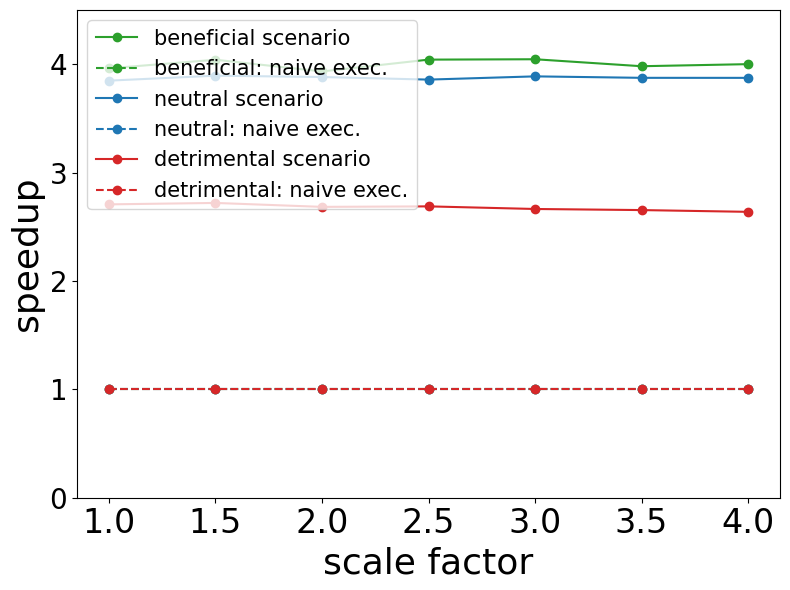

In [9]:
optimization = "common_subexpression_elimination"
scale_factors = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
variant_count = 4
ideal_df = load_csv_result_data_scale_factors(optimization, "ideal", scale_factors, variant_count)
average_df = load_csv_result_data_scale_factors(optimization, "average", scale_factors, variant_count)
worst_df = load_csv_result_data_scale_factors(optimization, "worst", scale_factors, variant_count)
plot_runtimes({'beneficial scenario;beneficial: naive exec.': (ideal_df['analysis_result_with_opt'], ideal_df['analysis_result_without_any_opt']),
               'neutral scenario;neutral: naive exec.': (average_df['analysis_result_with_opt'], average_df['analysis_result_without_any_opt']),
               'detrimental scenario;detrimental: naive exec.': (worst_df['analysis_result_with_opt'], worst_df['analysis_result_without_any_opt'])},
              scale_factors,
              f"{optimization}_scale_factors")

max_runtime_seen
59201.093673706055
analysis_result_without_any_opt
projection_push_up
ideal
4.0
max_runtime_seen
11426.416635513306
analysis_result_without_any_opt
projection_push_up
average
4.0
max_runtime_seen
8090.53111076355
analysis_result_without_any_opt
projection_push_up
worst
4.0


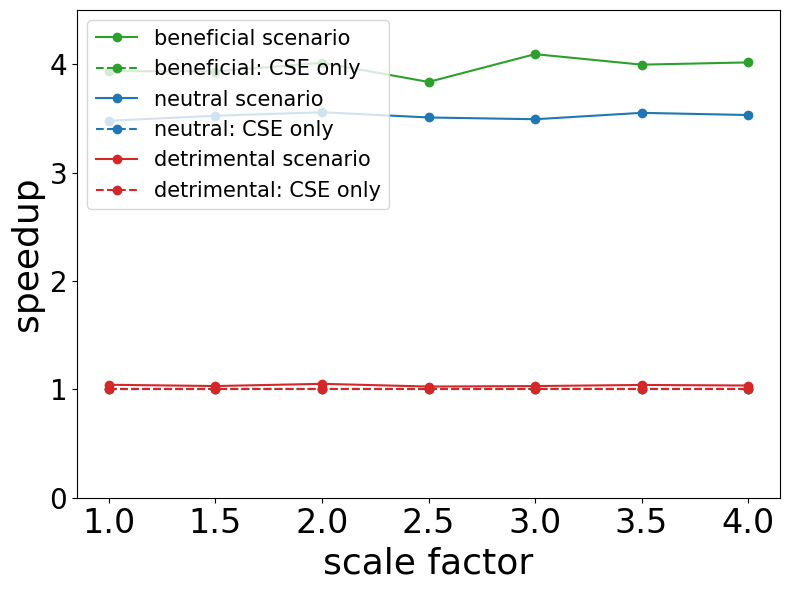

In [10]:
optimization = "projection_push_up"
scale_factors = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
variant_count = 4
ideal_df = load_csv_result_data_scale_factors(optimization, "ideal", scale_factors, variant_count)
average_df = load_csv_result_data_scale_factors(optimization, "average", scale_factors, variant_count)
worst_df = load_csv_result_data_scale_factors(optimization, "worst", scale_factors, variant_count)
plot_runtimes({'beneficial scenario;beneficial: CSE only': (ideal_df['analysis_result_with_opt_rule'], ideal_df['analysis_result_without_any_opt']),
               'neutral scenario;neutral: CSE only': (average_df['analysis_result_with_opt_rule'], average_df['analysis_result_without_any_opt']),
               'detrimental scenario;detrimental: CSE only': (worst_df['analysis_result_with_opt_rule'], worst_df['analysis_result_without_any_opt'])},
              scale_factors,
              f"{optimization}_scale_factors")


max_runtime_seen
14067.171573638916
analysis_result_without_any_opt
udf_split_and_reuse
ideal
4.0
max_runtime_seen
10622.20311164856
analysis_result_without_any_opt
udf_split_and_reuse
average
4.0
max_runtime_seen
4447.500228881836
analysis_result_without_any_opt
udf_split_and_reuse
worst_w_safety
4.0


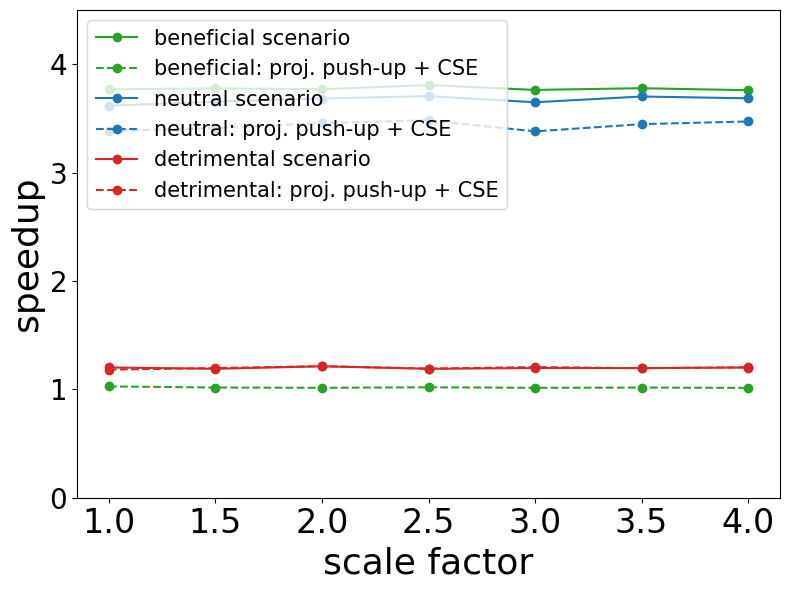

In [11]:
optimization = "udf_split_and_reuse"
scale_factors = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
variant_count = 4
ideal_df = load_csv_result_data_scale_factors(optimization, "ideal", scale_factors, variant_count)
average_df = load_csv_result_data_scale_factors(optimization, "average", scale_factors, variant_count)
worst_df = load_csv_result_data_scale_factors(optimization, "worst_w_safety", scale_factors, variant_count)
plot_runtimes({'beneficial scenario;beneficial: proj. push-up + CSE': (ideal_df['analysis_result_with_reuse_opt_rule'], ideal_df['analysis_result_with_push_up_opt_rule']),
               'neutral scenario;neutral: proj. push-up + CSE': (average_df['analysis_result_with_reuse_opt_rule'], average_df['analysis_result_with_push_up_opt_rule']),
               'detrimental scenario;detrimental: proj. push-up + CSE': (worst_df['analysis_result_with_reuse_opt_rule'], worst_df['analysis_result_with_push_up_opt_rule'])},
              scale_factors,
              f"{optimization}_scale_factors")

max_runtime_seen
62072.04008102417
analysis_result_without_any_opt
filter_addition_push_up
ideal
4.0
max_runtime_seen
10383.421182632446
analysis_result_without_any_opt
filter_addition_push_up
average
4.0
max_runtime_seen
3944.673538208008
analysis_result_without_any_opt
filter_addition_push_up
worst_wo_original
4.0
max_runtime_seen
19502.55489349365
analysis_result_without_any_opt
filter_addition_push_up
worst_w_original
4.0


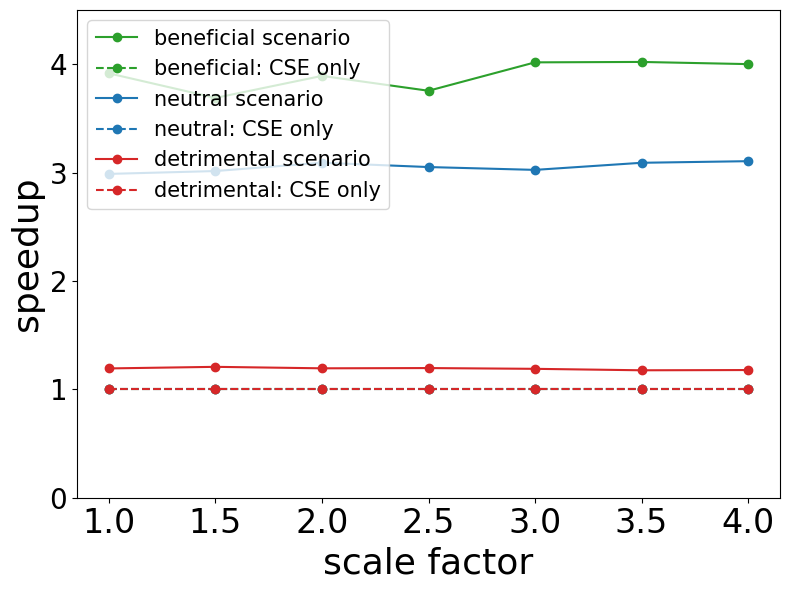

In [12]:
optimization = "filter_addition_push_up"
scale_factors = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
variant_count = 4
ideal_df = load_csv_result_data_scale_factors(optimization, "ideal", scale_factors, variant_count)
average_df = load_csv_result_data_scale_factors(optimization, "average", scale_factors, variant_count)
worst_wo_original_df = load_csv_result_data_scale_factors(optimization, "worst_wo_original", scale_factors, variant_count)
worst_w_original_df = load_csv_result_data_scale_factors(optimization, "worst_w_original", scale_factors, variant_count)
plot_runtimes({'beneficial scenario;beneficial: CSE only': (ideal_df['analysis_result_with_opt_rule'], ideal_df['analysis_result_without_any_opt']),
               'neutral scenario;neutral: CSE only': (average_df['analysis_result_with_opt_rule'], average_df['analysis_result_without_any_opt']),
               #'disadvantageous: w/o original': (worst_wo_original_df['analysis_result_with_opt_rule'], worst_wo_original_df['analysis_result_without_any_opt']),
               'detrimental scenario;detrimental: CSE only': (worst_w_original_df['analysis_result_with_opt_rule'], worst_w_original_df['analysis_result_without_any_opt'])},
              scale_factors,
              f"{optimization}_scale_factors")

max_runtime_seen
64385.85114479065
analysis_result_without_any_opt
operator_deletion_filter_push_up
ideal
4.0
max_runtime_seen
10500.650405883787
analysis_result_without_any_opt
operator_deletion_filter_push_up
average
4.0
max_runtime_seen
3609.608173370361
analysis_result_without_any_opt
operator_deletion_filter_push_up
worst_wo_safety
4.0
max_runtime_seen
15179.497957229614
analysis_result_without_any_opt
operator_deletion_filter_push_up
worst_w_safety
4.0
max_runtime_seen
16102.442026138306
analysis_result_without_any_opt
operator_deletion_filter_push_up
worst_safety_too_defensive
4.0
max_runtime_seen
16541.42689704895
analysis_result_without_any_opt
operator_deletion_filter_push_up
worst_case_only_some_filters_worth_pushing_up
4.0


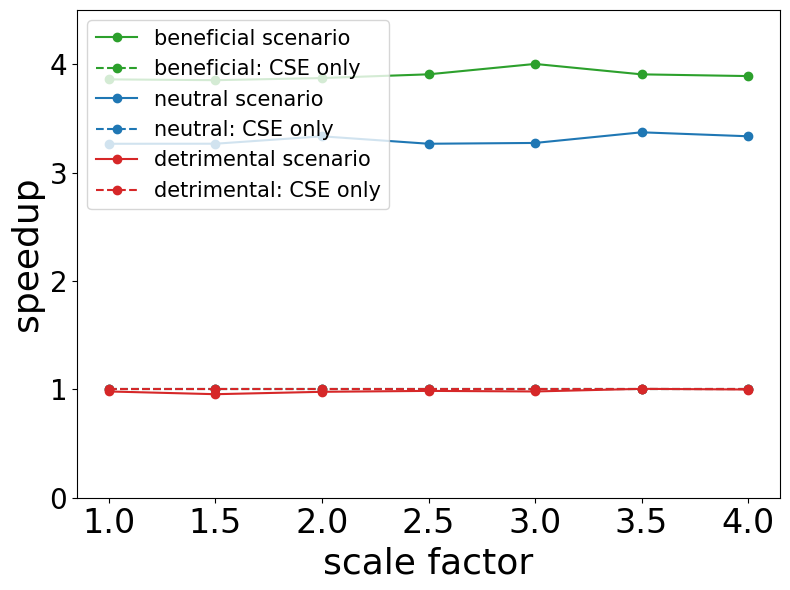

In [13]:
optimization = "operator_deletion_filter_push_up"
scale_factors = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
variant_count = 4
ideal_df = load_csv_result_data_scale_factors(optimization, "ideal", scale_factors, variant_count)
average_df = load_csv_result_data_scale_factors(optimization, "average", scale_factors, variant_count)
worst_wo_safety_df = load_csv_result_data_scale_factors(optimization, "worst_wo_safety", scale_factors, variant_count)
worst_w_safety_df = load_csv_result_data_scale_factors(optimization, "worst_w_safety", scale_factors, variant_count)
worst_safety_too_defensive_df = load_csv_result_data_scale_factors(optimization, "worst_safety_too_defensive", scale_factors, variant_count)
worst_case_only_some_filters_worth_pushing_up_df = load_csv_result_data_scale_factors(optimization, "worst_case_only_some_filters_worth_pushing_up", scale_factors, variant_count)
plot_runtimes({'beneficial scenario;beneficial: CSE only': (ideal_df['analysis_result_with_opt_rule'], ideal_df['analysis_result_without_any_opt']),
               'neutral scenario;neutral: CSE only': (average_df['analysis_result_with_opt_rule'], average_df['analysis_result_without_any_opt']),
               #'detrimental: w/o safety': (worst_wo_safety_df['analysis_result_with_opt_rule'], worst_wo_safety_df['analysis_result_without_any_opt']),
               'detrimental scenario;detrimental: CSE only': (worst_w_safety_df['analysis_result_with_opt_rule'], worst_w_safety_df['analysis_result_without_any_opt']),
               #'detrimental: safety too defensive': (worst_safety_too_defensive_df['analysis_result_with_opt_rule'], worst_safety_too_defensive_df['analysis_result_without_any_opt']),
               #'detrimental: only some filters worth pushing up': (worst_case_only_some_filters_worth_pushing_up_df['analysis_result_with_opt_rule'], worst_case_only_some_filters_worth_pushing_up_df['analysis_result_without_any_opt'])
               },
              scale_factors,
              f"{optimization}_scale_factors")

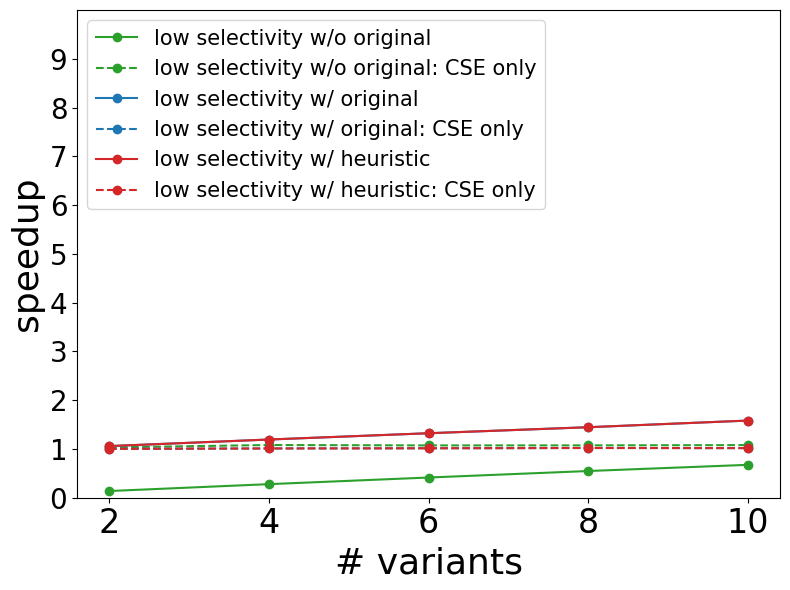

In [19]:
optimization = "filter_addition_push_up"
variant_counts = [2, 4, 6, 8, 10]
row_count = "1.0"
ideal_df = load_csv_result_data_variant_counts(optimization, "ideal", variant_counts, row_count)
average_df = load_csv_result_data_variant_counts(optimization, "average", variant_counts, row_count)
worst_wo_original_df = load_csv_result_data_variant_counts(optimization, "worst_wo_original", variant_counts, row_count)
worst_w_original_df = load_csv_result_data_variant_counts(optimization, "worst_w_original", variant_counts, row_count)
worst_wo_original_w_heuristic_df = load_csv_result_data_variant_counts(optimization, "worst_w_original_w_heuristic", variant_counts, row_count)
plot_runtimes({'low selectivity w/o original;low selectivity w/o original: CSE only': (worst_wo_original_df['analysis_result_with_opt_rule'], worst_wo_original_df['analysis_result_without_opt_rule']),
               'low selectivity w/ original;low selectivity w/ original: CSE only': (worst_w_original_df['analysis_result_with_opt_rule'], worst_w_original_df['analysis_result_without_opt_rule']),
               'low selectivity w/ heuristic;low selectivity w/ heuristic: CSE only': (worst_w_original_df['analysis_result_with_opt_rule'], worst_w_original_df['analysis_result_without_opt_rule'])
               },
              variant_counts,
              f"{optimization}_special_scenarios")

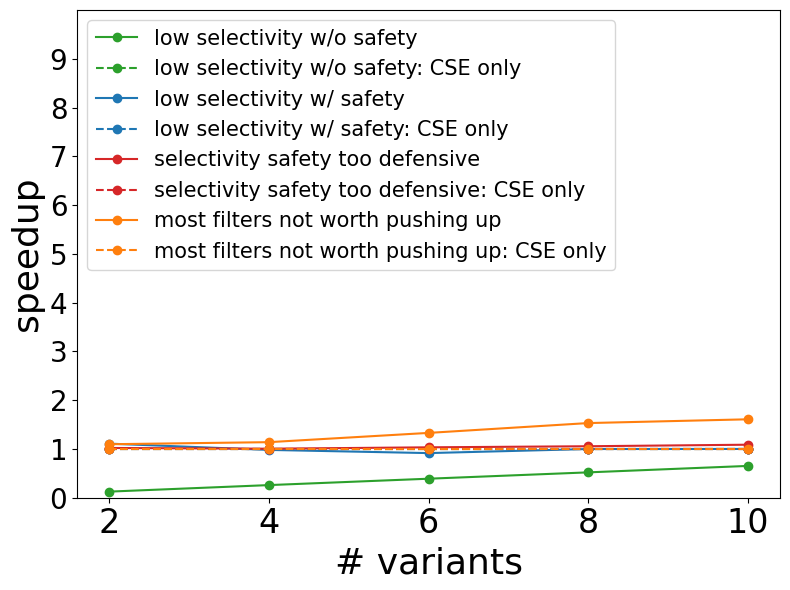

0    1.096662
0    1.139087
0    1.329009
0    1.530723
0    1.607946
Name: analysis_result_with_opt_rule, dtype: float64


In [15]:
optimization = "operator_deletion_filter_push_up"
variant_counts = [2, 4, 6, 8, 10]
scale_factor = "1.0"
worst_wo_safety_df = load_csv_result_data_variant_counts(optimization, "worst_wo_safety", variant_counts, scale_factor)
worst_w_safety_df = load_csv_result_data_variant_counts(optimization, "worst_w_safety", variant_counts, scale_factor)
worst_safety_too_defensive_df = load_csv_result_data_variant_counts(optimization, "worst_safety_too_defensive", variant_counts, scale_factor)
worst_case_only_some_filters_worth_pushing_up_df = load_csv_result_data_variant_counts(optimization, "worst_case_only_some_filters_worth_pushing_up", variant_counts, scale_factor)
plot_runtimes({'low selectivity w/o safety;low selectivity w/o safety: CSE only': (worst_wo_safety_df['analysis_result_with_opt_rule'], worst_wo_safety_df['analysis_result_without_any_opt']),
               'low selectivity w/ safety;low selectivity w/ safety: CSE only': (worst_w_safety_df['analysis_result_with_opt_rule'], worst_w_safety_df['analysis_result_without_any_opt']),
               'selectivity safety too defensive;selectivity safety too defensive: CSE only': (worst_safety_too_defensive_df['analysis_result_with_opt_rule'], worst_safety_too_defensive_df['analysis_result_without_any_opt']),
               'most filters not worth pushing up;most filters not worth pushing up: CSE only': (worst_case_only_some_filters_worth_pushing_up_df['analysis_result_with_opt_rule'], worst_case_only_some_filters_worth_pushing_up_df['analysis_result_without_any_opt'])
               },
              variant_counts,
              f"{optimization}_special_scenarios")
print(worst_case_only_some_filters_worth_pushing_up_df['analysis_result_with_opt_rule'])

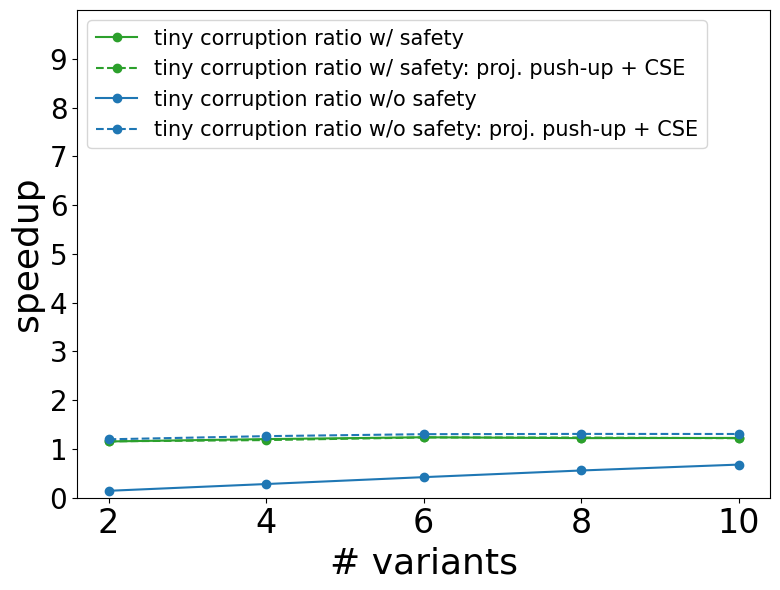

In [16]:
optimization = "udf_split_and_reuse"
variant_counts = [2, 4, 6, 8, 10]
row_count = "1.0"
ideal_df = load_csv_result_data_variant_counts(optimization, "ideal", variant_counts, row_count)
average_df = load_csv_result_data_variant_counts(optimization, "average", variant_counts, row_count)
worst_w_safety_df = load_csv_result_data_variant_counts(optimization, "worst_w_safety", variant_counts, row_count)
worst_wo_safety_df = load_csv_result_data_variant_counts(optimization, "worst_wo_safety", variant_counts, row_count)
worst_constant_df = load_csv_result_data_variant_counts(optimization, "worst_constant", variant_counts, row_count)

plot_runtimes({#'beneficial scenario': (ideal_df['analysis_result_with_reuse_opt_rule'], ideal_df['analysis_result_with_push_up_opt_rule']),
               #'neutral scenario': (average_df['analysis_result_with_reuse_opt_rule'], average_df['analysis_result_with_push_up_opt_rule']),
               'tiny corruption ratio w/ safety;tiny corruption ratio w/ safety: proj. push-up + CSE': (worst_w_safety_df['analysis_result_with_reuse_opt_rule'], worst_w_safety_df['analysis_result_with_push_up_opt_rule']),
              'tiny corruption ratio w/o safety;tiny corruption ratio w/o safety: proj. push-up + CSE': (worst_wo_safety_df['analysis_result_with_reuse_opt_rule'], worst_wo_safety_df['analysis_result_with_push_up_opt_rule']),
               #'detrimental scenario: constant': (worst_constant_df['analysis_result_with_reuse_opt_rule'], worst_constant_df['analysis_result_with_push_up_opt_rule'])
              },
              variant_counts,
              f"{optimization}_special_scenarios")
